In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import os
from plotting_fxns import *
%load_ext autoreload
%autoreload 2
import socket
if 'trace' in socket.gethostname():
    base_fp = '/trace/group/rounce/cvwilson/Firn/'
sites = ['EC','T','Z','KPS']
out_fp = base_fp + 'Output/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


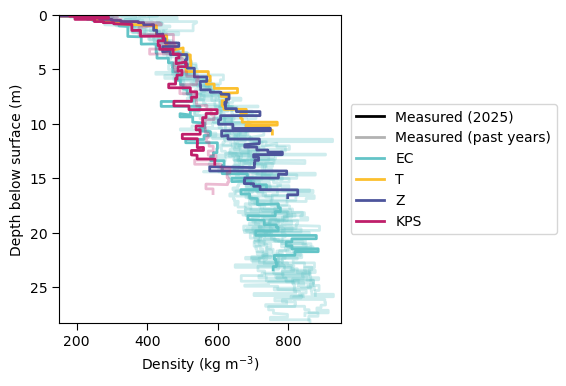

In [18]:
dates = [dates_wolverine_spring,['2025_04_20'],['2025_04_20'],dates_kahiltna_spring]
compare_site_data(sites,dates, savefig=True)

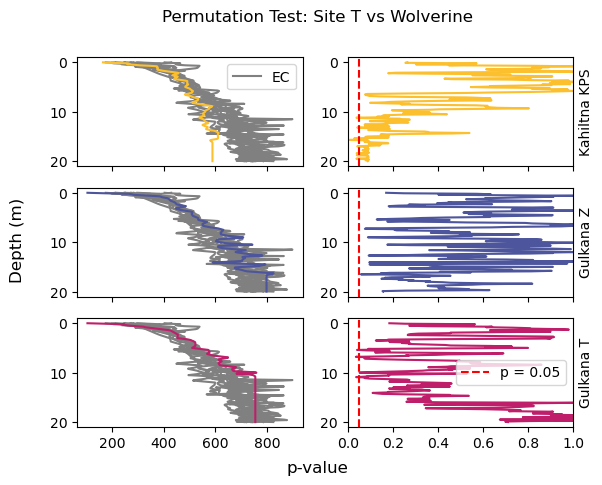

Null hypothesis cannot be rejected at Kahiltna KPS: p = 0.0876
Null hypothesis cannot be rejected at Gulkana Z: p = 0.3514
Null hypothesis cannot be rejected at Gulkana T: p = 0.3475


In [53]:
# Generate density profiles at consistent depths for statistical comparison
depths = np.arange(0, 20.1, 0.1)
date_dict = {'Z':['2025_04_20'],'T':['2025_04_20'],
             'KPS':dates_kahiltna_spring, 'EC':dates_wolverine_spring}
site_cores_interp = {}
for site in ['EC','KPS','Z','T']:
    site_cores_interp[site] = []
    for date in date_dict[site]:
        density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)
        layer_middles = layer_tops + (layer_bottoms - layer_tops) / 2
        density_interp = np.interp(depths, layer_middles, density_meas)
        site_cores_interp[site].append(density_interp)
site_cores_avg = {}
for site in site_cores_interp:
    avg_profile = np.mean(site_cores_interp[site], axis=0)
    site_cores_avg[site] = avg_profile

# Permutation test for each individual depth
plot_permutation_test(site_cores_interp['EC'], site_cores_avg, ['KPS','Z','T'], depths)

# Permutation test for the entire profile
for s,site in enumerate(['KPS','Z','T']):
    glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
    p_val, _, _ = profile_permutation_test(site_cores_interp['EC'], site_cores_avg[site], n_permutations=10000)
    if p_val <= 0.05:
        print(f'Profiles are significantly different at {glacier} {site}: p = {p_val}')
    else:
        print(f'Null hypothesis cannot be rejected at {glacier} {site}: p = {p_val}')

Mean Absolute Error: 37.66823334098577 kg m-3
Mean Error (Bias): -22.845380261429142 kg m-3


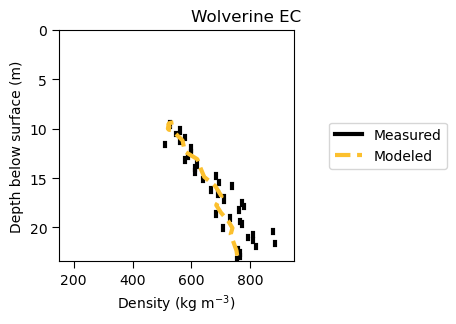

In [61]:
# SIMPLE PLOT
site = 'EC'
rho = 'GSFC2020'
var = 'density'

# measured data
date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

# modeled data
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
cfm_fn = base_fp + f'Output/{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5'
density_mod, depth_mod = get_var_modeled(cfm_fn, date, var)

# crop to firn, excluding seasonal snow
snow_df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_snowdepth.csv')
min_depth = snow_df.loc[snow_df['date'] == date, 'snowdepth'].values
density_meas = density_meas[layer_tops >= min_depth]
layer_bottoms = layer_bottoms[layer_tops >= min_depth]
layer_tops = layer_tops[layer_tops >= min_depth]
density_mod = density_mod[depth_mod >= min_depth]
depth_mod = depth_mod[depth_mod >= min_depth]

# plot
simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod), print_error=True)

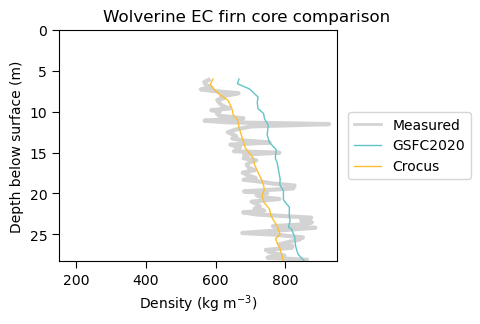

In [64]:
# DENSIFICATION COMPARISON
for site in ['EC']: # 
    all_measured = []
    all_modeled = []
    all_labels = []
    for rho in ['GSFC2020','Crocus']: 
        # specify  results filename
        glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
        cfm_fn = base_fp + f'Output/{glacier}{site}/{glacier}{site}_{rho}/CFMresults.hdf5'

        # load data
        date = dates_wolverine_spring[1]
        density_mod, depth_mod = get_var_modeled(cfm_fn, date, 'density')
        density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

        # get label
        label = rho

        # crop seasonal snow
        snow_df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_snowdepth.csv')
        min_depth = snow_df.loc[snow_df['date'] == date, 'snowdepth'].values
        density_meas = density_meas[layer_tops >= min_depth]
        layer_bottoms = layer_bottoms[layer_tops >= min_depth]
        layer_tops = layer_tops[layer_tops >= min_depth]
        density_mod = density_mod[depth_mod >= min_depth]
        depth_mod = depth_mod[depth_mod >= min_depth]

        # store data
        all_measured.append((density_meas, layer_bottoms, layer_tops))
        all_modeled.append((density_mod, depth_mod))
        all_labels.append(label)

    # plot
    simple_comparison(site, all_measured, all_modeled, all_labels, print_error=False, savefig=False)
                        # savefig=f'{glacier}{site}_{rho}_srho_comparison.png',
                        # t=f'{glacier.capitalize()} {site}; {rho}')

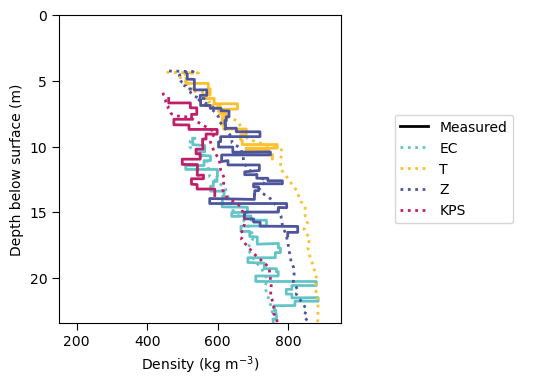

In [ ]:
# ALL SITES SIMPLE FIGURE
all_measured = []
all_modeled = []
rho = 1
for site in sites:
    # measured
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    date = dates_wolverine_spring[-1] if site == 'EC' else dates_kahiltna_spring[-1] if site == 'KPS' else '2025_04_20'
    density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

    # modeled
    cfm_fn_dict = {'Z':f'{glacier}{site}/{glacier}{site}_{rho}_0/CFMresults.hdf5',
                   'T':f'{glacier}{site}/{glacier}{site}_1.1_0/CFMresults.hdf5',
                   'EC':f'{glacier}{site}/{glacier}{site}_{rho}_0/CFMresults.hdf5',
                   'KPS':f'{glacier}{site}/{glacier}{site}_{rho}_0/CFMresults.hdf5'}
    cfm_fn = cfm_fn_dict[site]
    density_mod, depth_mod = get_var_modeled(out_fp + cfm_fn, date, 'density')

    # get depth of seasonal snow
    snow_df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_snowdepth.csv')
    min_depth = snow_df.loc[snow_df['date'] == date, 'snowdepth'].values
    density_meas = density_meas[layer_tops >= min_depth]
    layer_bottoms = layer_bottoms[layer_tops >= min_depth]
    layer_tops = layer_tops[layer_tops >= min_depth]
    density_mod = density_mod[depth_mod >= min_depth]
    depth_mod = depth_mod[depth_mod >= min_depth]
                                         
    # simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod))
    all_measured.append((density_meas, layer_bottoms, layer_tops))
    all_modeled.append((density_mod, depth_mod))

compare_sites(all_measured, all_modeled, sites)

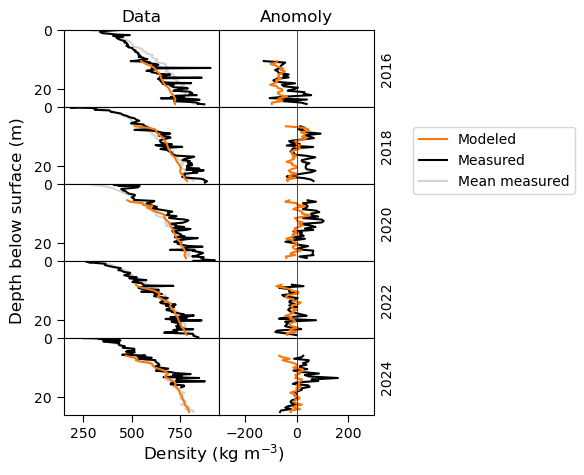

In [54]:
# WOLVERINE ALL YEARS
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
data = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5','r')
# plot_wolverine_years(data, False)
plot_years_together(data, site, print_error=False, every=2, dates='spring', savefig = f'{glacier}{site}_firn_core_anomoly.png')

In [8]:
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
avg_depths = np.arange(0, 25.5, 0.5)
interp_density_meas = []
interp_density_mod = []
all_density_meas = []
all_density_mod = []
for date in dates_wolverine_spring:
    df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_{date}.csv')
    layer_middle = df['SBD'].values - df['length'].values / 2
    dens_middle = df['density'].values
    dens_interp = np.interp(avg_depths, layer_middle, dens_middle)
    dens_interp[avg_depths > np.max(layer_middle)] = np.nan
    interp_density_meas.append(dens_interp)

    output = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5','r')
    all_decimal_time = output['density'][:, 0]
    target_time = to_decimal_year(pd.to_datetime(date.replace('_','/')))[0]
    index = np.argmin(np.abs(all_decimal_time - target_time))

    # get depth and data arrays
    depth_mod = output['depth'][1:]
    density_mod = output['density'][index, 1:]
    if len(density_mod) == 1:
        density_mod = density_mod[0]
    dens_interp = np.interp(avg_depths, depth_mod, density_mod)
    interp_density_mod.append(dens_interp)

    # append actual data
    # all_density_meas.append((layer_middle, dens_middle))
    # all_density_mod.append((depth_mod[depth_mod <= 25.5], density_mod[depth_mod <= 25.5]))
mean_measured_profile = np.nanmean(interp_density_meas, axis=0)
mean_modeled_profile = np.nanmean(interp_density_mod, axis=0)

# standard deviation at depth
std_meas_profile = np.nanstd(interp_density_meas, axis=0)
std_mod_profile  = np.nanstd(interp_density_mod, axis=0)

# MAE
mae_meas = [np.nanmean(np.abs(profile - mean_measured_profile)) for profile in interp_density_meas]
mae_mod  = [np.nanmean(np.abs(profile - mean_modeled_profile)) for profile in interp_density_mod]

print('                         Modeled   Measured')
print(f'Mean standard deviation: {np.mean(std_mod_profile):<10.3f} {np.mean(std_meas_profile):<10.3f}')
print(f'Mean MAE:                {np.mean(mae_mod):<10.3f} {np.mean(mae_meas):<10.3f}')

                         Modeled   Measured
Mean standard deviation: 25.897     42.802    
Mean MAE:                21.260     34.796    


In [84]:
# COMPARE DENSIFICATION SCHEMES
# all_rho = [
#             # >> RECOMMENDED BY MAX
#             'GSFC2020','Crocus' 
#             # >> FUNCTIONAL
#             # 'HLdynamic','Arthern2010S','Arthern2010T', 'Barnola1991',
#             # 'Ligtenberg2011','Crocus','KuipersMunneke2015','GSFC2020',
#             # >> BROKEN
#                 # 'HLSigfus','Li2011','Helsen2008', 'Ligtenberg2011',
#                 # 'Arthern2010S','Arthern2010T','Li2015','Goujon2003',
#                 # 'Barnola1991','Morris2014','KuipersMunneke2015',
# ]

# fn = f'{glacier}{site}/CFMresults_{glacier}{site}_RHO_0/CFMresults.hdf5'
# fig, ax = compare_densification(fn, all_rho, date, (density_meas, layer_bottoms, layer_tops))
# date_label = date.replace('_','/')
# fig.suptitle(f'Site {site} firn core comparison, {date_label}',y=0.97)
# plt.show()

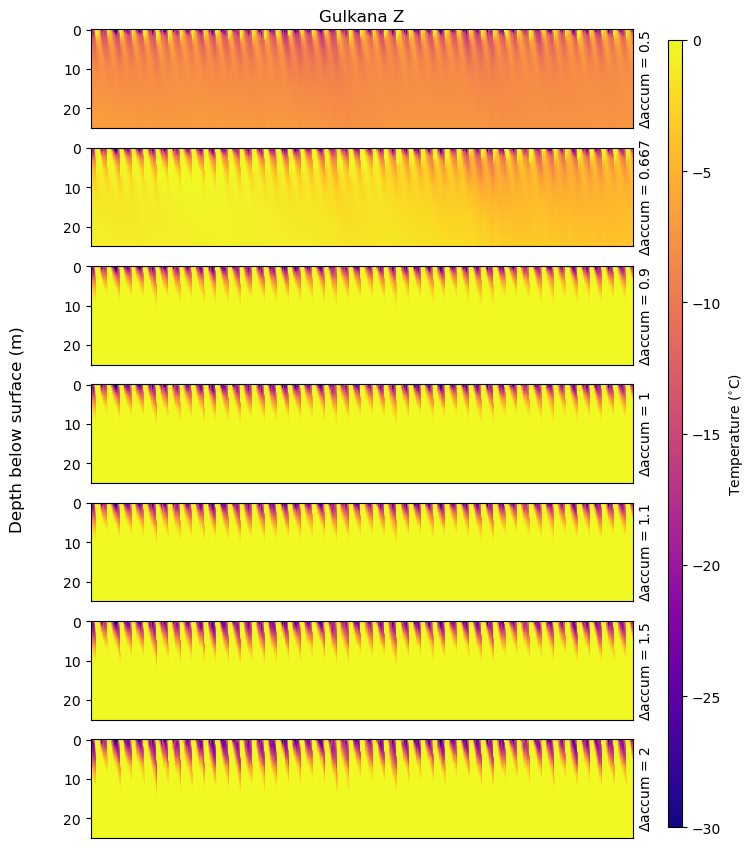

In [23]:
site = 'Z'
var_labels = {'temperature':'Temperature ($^{\circ}$C)','LWC':'Water content (m$^{3}$)',
              'age':'Age (years)','density':'Density (kg m$^{-3}$)'}
var_ranges = {'temperature':(-30, 0), 'LWC':(0, 0.001),
              'age':(0, 25), 'density':(350, 800)}
var_cmaps = {'temperature':'plasma','LWC':'cmr.freeze_r','density':'cmr.toxic','age':'cmr.emerald'}

loop_on = 'accum'
for var in ['temperature']:
    if loop_on == 'sites':
        loop = ['EC','T','Z','KPS']
    elif loop_on in ['surftemp','temp']:
        loop = [-5, -2, -1, 0, 1, 2, 5]
    elif loop_on == 'accum':
        loop = [0.5,0.667,0.9,1,1.1,1.5,2]
    fig, axes = plt.subplots(len(loop), figsize=(7, len(loop)*1.5), sharex=True)
    norm = mpl.colors.Normalize(vmin=var_ranges[var][0], vmax=var_ranges[var][1])
    if len(loop) == 1:
        axes = [axes]
    for ax,val in zip(axes, loop):
        if loop_on == 'sites':
            site = val
        glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
        n_steps = 5
        max_depth = 25
        # output = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5')
        if loop_on == 'sites':
            fstring = '1'
        elif loop_on == 'surftemp':
            val_string = '+'+str(val) if val > 0 else str(val)
            fstring = 'TS' + str(val_string)
        elif loop_on == 'temp':
            fstring = '+'+str(val) if val > 0 else str(val)
        elif loop_on == 'accum':
            fstring = str(val)
        output = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_{fstring}_0/CFMresults.hdf5')

        # find layer tops and bottoms
        depth_mod = output['depth'][1:]
        max_idx = np.where(depth_mod > max_depth)[0][0]
        depth_mod = depth_mod[:max_idx]
        layer_tops = np.array(depth_mod)
        dz = np.diff(depth_mod)
        layer_bottoms = np.append(layer_tops[1:] + dz, np.array([layer_tops[-1] + 0.05]))

        # get times and data into the correct format
        times = output['density'][1:, 0]
        D, T = np.meshgrid(depth_mod, times)
        var_data = output[var][1:, 1:max_idx + 1]
        if var == 'temperature':
            var_data -= 273.15
        output.close()

        c = ax.pcolormesh(T, D, var_data,shading='auto', cmap=var_cmaps[var], norm=norm)
        ax.invert_yaxis()
        ax.set_xlim(1980, 2025)
        if ax != axes[-1]:
            ax.set_xticks([])
        if loop_on == 'sites':
            ax.set_ylabel(f'{glacier.capitalize()} {site}')
        else:
            ax.set_ylabel(f'$\Delta${loop_on} = {val}')
        ax.yaxis.set_label_position('right')
    cax = fig.add_axes([0.95, 0.12, 0.02, 0.75])
    cb = fig.colorbar(c, cax=cax)
    cb.set_label(var_labels[var])
    fig.supylabel('Depth below surface (m)', x=0.01)
    out_fn = f'Figs/CFM_by{loop_on}_{var}.png'
    if loop_on != 'sites':
        axes[0].set_title(f'{glacier.capitalize()} {site}')
        out_fn = out_fn.replace('.png',f'_{glacier}{site}.png')
    plt.savefig(base_fp+out_fn, dpi=200, bbox_inches='tight')
    plt.show()

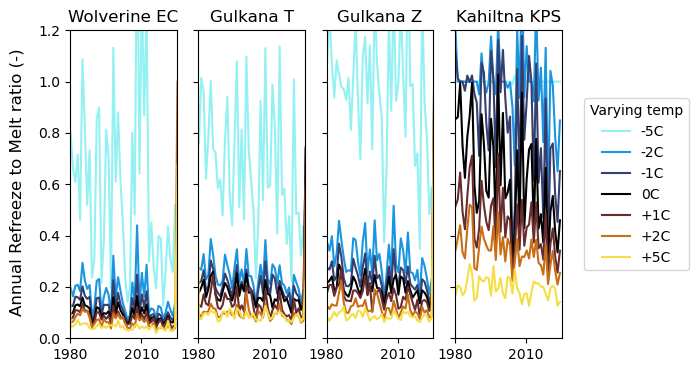

In [44]:
# Plot vector timeseries
var_labels = {'refreeze':'Refreeze (m w.e.)','DIP':'Firn Air Content (m)',
              'runoff':'Runoff (m w.e.)','meltvol':'Melt (m w.e.)',
              'refreeze_ratio':'Refreeze to Melt ratio (-)'}
sites = ['EC','T','Z','KPS']
var = 'meltvol'
loop_on = 'temp'
plot_type = 'annual'    # 'cumulative' or 'annual'
cmap = cmr.iceburn
norm = mpl.colors.Normalize(vmin=0, vmax=6)
for var in ['refreeze_ratio']:
    fig, axes = plt.subplots(1, len(sites) + 1, figsize=(len(sites)*2, 4), 
                         sharex=True, sharey=True)
    for ax, site in zip(axes, sites):
        if loop_on in ['surftemp','temp']:
            loop = [-5, -2, -1, 0, 1, 2, 5]
        elif loop_on == 'accum':
            loop = [0.5,0.667,0.9,1,1.1,1.5,2]

        for i, val in enumerate(loop):
            glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
            n_steps = 5
            max_depth = 25
            # output = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5')
            if loop_on == 'sites':
                fstring = '1'
            elif loop_on == 'surftemp':
                val_string = '+'+str(val) if val > 0 else str(val)
                fstring = 'TS' + str(val_string)
            elif loop_on == 'temp':
                fstring = '+'+str(val) if val > 0 else str(val)
            elif loop_on == 'accum':
                fstring = str(val)
            output = h5py.File(base_fp + f'Output/{glacier}{site}/{glacier}{site}_{fstring}_0/CFMresults.hdf5')

            # get times and data into the correct format
            times = np.array(from_decimal_year(output['density'][1:, 0]))
            if var != 'refreeze_ratio':
                var_data = output[var][1:, 1]
            elif var == 'refreeze_ratio':
                df = pd.DataFrame({'melt': output['meltvol'][1:, 1], 'refreeze':output['refreeze'][1:, 1]}, index=times)
                df = df.resample('YS-APR').sum()
                var_data = df['refreeze'] / df['melt']
                times = df.index
            if var in ['meltvol','refreeze','runoff'] and plot_type == 'cumulative':
                var_data = np.cumsum(var_data)
            elif var != 'refreeze_ratio' and plot_type == 'annual':
                df = pd.DataFrame({var: var_data}, index=times)
                if var in ['meltvol','refreeze','runoff']:
                    df = df.resample('YS').sum()
                else:
                    df = df.loc[pd.date_range(times[0], times[-1],freq='YS')]
                var_data = df.values
                times = df.index

            ax.plot(times, var_data, c=cmap(norm(i)))
            ax.set_ylim(0, 1.2)
            lstring = fstring + 'C' if 'temp' in loop_on else fstring
            if ax == axes[0]:
                axes[-1].plot(np.nan, np.nan, c=cmap(norm(i)), label=lstring)
            ax.set_xlim(pd.to_datetime('1980-04-20'), pd.to_datetime('2025'))
            ax.set_xticks(pd.date_range(times[0], times[-1], freq='30YS'))
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
        ax.set_title(f'{glacier.capitalize()} {site}')
    axes[-1].legend(loc='center',title=f'Varying {loop_on}')
    axes[-1].axis('off')
    title = plot_type.capitalize()+' '+var_labels[var] if var != 'DIP' else var_labels[var]
    fig.supylabel(title,x=0.05)
    plt.savefig(base_fp+f'Figs/CFM_site_comparison_{var}_varying{loop_on}.png', dpi=200, bbox_inches='tight')
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


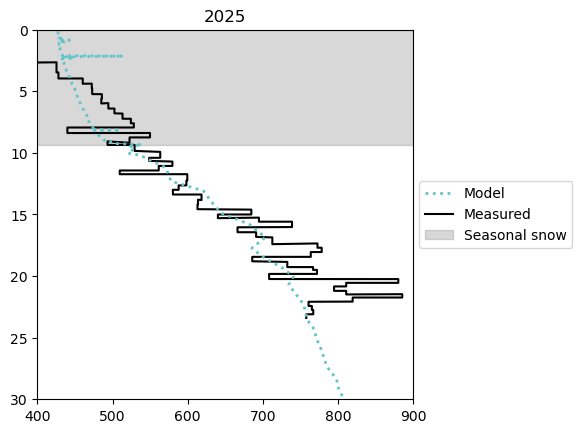

In [11]:
# ANIMATE
site = 'EC'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    
all_measured = []
all_modeled = []
all_seasonal = []
for date in dates_wolverine_spring:
    density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

    # modeled
    cfm_fn = f'{glacier}{site}/{glacier}{site}_1_0/CFMresults.hdf5'
    density_mod, depth_mod = get_var_modeled(out_fp + cfm_fn, date, 'density')

    # get depth of seasonal snow
    snow_df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_snowdepth.csv')
    min_depth = snow_df.loc[snow_df['date'] == date, 'snowdepth'].values
    # density_meas = density_meas[layer_tops >= min_depth]
    # layer_bottoms = layer_bottoms[layer_tops >= min_depth]
    # layer_tops = layer_tops[layer_tops >= min_depth]
    # density_mod = density_mod[depth_mod >= min_depth]
    # depth_mod = depth_mod[depth_mod >= min_depth]
                                         
    # simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod))
    all_measured.append((density_meas, layer_bottoms, layer_tops))
    all_modeled.append((density_mod, depth_mod))
    all_seasonal.append(min_depth)

animate(all_modeled, all_measured, dates_wolverine_spring, all_seasonal)

In [13]:
from plotting_fxns import *

In [48]:
# ANIMATE MULTIPLE SITES
all_measured = []
all_modeled = []
all_seasonal = []
for site in sites:
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
        
    site_measured = []
    site_modeled = []
    site_seasonal = []
    for date in dates_wolverine_spring:
        if site == 'EC':
            density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)
        elif date[:4] == '2025':
            date = '2025_04_20' if glacier == 'gulkana' else dates_kahiltna_spring[-1]
            density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)
        elif date[:4] == '2024' and site == 'KPS':
            date = dates_kahiltna_spring[0]
            density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)
        else:
            density_meas, layer_tops, layer_bottoms = ([],[],[])

        # modeled
        ff = '1' if site != 'T' else '1.1'
        cfm_fn = f'{glacier}{site}/{glacier}{site}_{ff}_0/CFMresults.hdf5'
        density_mod, depth_mod = get_var_modeled(out_fp + cfm_fn, date, 'density')

        # get depth of seasonal snow
        snow_df = pd.read_csv(f'../Data/cores/{glacier}/{glacier}{site}_snowdepth.csv')
        # if date in snow_df['date']:
        min_depth = snow_df.loc[snow_df['date'] == date, 'snowdepth'].values
        # add snow depths to each year at Gulkana/Kahiltna for nicer plot
        # else:
        #     min_depth = snow_df.loc[snow_df['date'] == date[:-4], 'snowdepth'].values
                                            
        # simple_plot(site, (density_meas, layer_bottoms, layer_tops), (density_mod, depth_mod))
        site_measured.append((density_meas, layer_bottoms, layer_tops))
        site_modeled.append((density_mod, depth_mod))
        site_seasonal.append(min_depth)
    all_modeled.append(site_modeled)
    all_measured.append(site_measured)
    all_seasonal.append(site_seasonal)

MovieWriter ffmpeg unavailable; using Pillow instead.


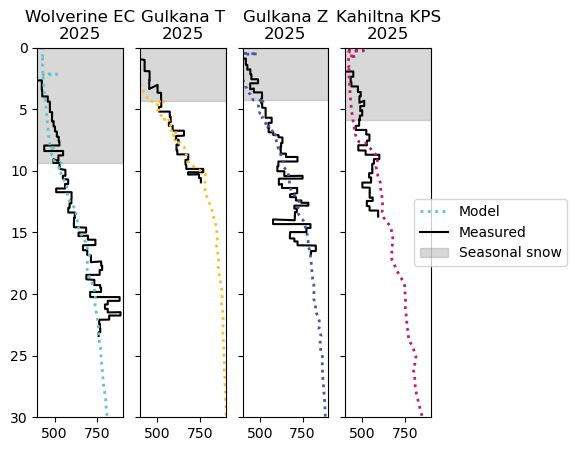

In [49]:
animate_sites(sites, all_modeled, all_measured, dates_wolverine_spring, all_seasonal)

In [ ]:
# Check energy balance model density performance
# site = 'Z'
# glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
# ds = xr.open_dataset(f'../../Model/Output/{glacier.capitalize()}_2025_08_28_long{site}_0.nc')
# fig, ax = plt.subplots()
# i = 0
# list_spring = []
# list_fall = []
# for file in os.listdir(f'../Data/cores/{glacier}/'):
#     if site in file:
#         date = file.split(site)[-1][1:].split('.csv')[0]
#         season = 'Spring' if ('_04_' in date or '_05_' in date) else 'Fall'
#         linestyle = '-' # ':' if ('_04_' in date or '_05_' in date) else '-'
#         i = 0 if season == 'Spring' else 1
        
#         # get the modeled density and depth on this date
#         ds_date = ds.sel(time=pd.to_datetime(date.replace('_','/')+' 00:00'))
#         layer_height = ds_date['layerheight'].values
#         dry_density_mod = ds_date['layerdensity'].values
#         water_mod = ds_date['layerwater'].values

#         # calculate actual density considering water content
#         density_mod = (dry_density_mod * layer_height + water_mod) / layer_height
#         depth_mod = np.array([np.sum(layer_height[:i+1])-(layer_height[i]/2) for i in range(len(layer_height))])

#         # get the measured density and depth
#         df = pd.read_csv(f'../Data/cores/{glacier}/' + file)
#         tops = df['SBD'] - df['length']
#         bottoms = df['SBD']
#         edges = np.append(tops.values[0], bottoms)
        
#         # interpolate
#         density_mod_edges = np.interp(edges, depth_mod, density_mod)
#         density_mod_middle = (density_mod_edges[:-1] + density_mod_edges[1:]) / 2
        
#         # compare
#         for top, bottom, mod, meas in zip(tops, bottoms, density_mod_middle, df['density'].values):
#             if bottom <= 2.7:
#                 # ax.plot([mod, mod], [top, bottom], c=colors[i], linestyle=linestyle)
#                 # ax.plot([meas, meas], [top, bottom], c=colors[i], linestyle=linestyle, alpha=0.5)
#                 ax.plot([mod - meas, mod - meas], [top, bottom], c=colors[i], linestyle=linestyle)
#                 if season == 'Spring':
#                     list_spring.append(mod - meas)
#                 else:
#                     list_fall.append(mod - meas)

#         # ax.plot(np.nan, np.nan, c=colors[i], label=date, linestyle=linestyle)
#         i += 1
#         if i >= len(colors):
#             i = 0

# list_spring = np.array(list_spring)
# list_fall = np.array(list_fall)
# print(f'Spring MAE: {np.mean(np.abs(list_spring)):.1f}')
# print(f'Spring Bias: {np.mean(list_spring):.1f}')
# print(f'Fall MAE: {np.mean(np.abs(list_fall)):.1f}')
# print(f'Fall Bias: {np.mean(list_fall):.1f}')

# ax.plot(np.nan, np.nan, c=colors[0],label='Spring')
# ax.plot(np.nan, np.nan, c=colors[1],label='Fall')

# ax.invert_yaxis()
# ax.axvline(0, linewidth=0.5, c='k')
# ax.set_ylim(2.5, 0)
# ax.set_xlim(-400, 400)
# ax.legend()
# ax.set_xlabel('Modeled $-$ Measured Density (kg m$^{-3}$)')
# ax.set_ylabel('Depth below surface (m)')
# ax.set_title(f'Comparison of PEBSI to measured density at {glacier.capitalize()} {site}')
# plt.show()